# Kernel SVM

#### Dual Hard-Margin SVM

$$
\begin{align}
\min_{\alpha} \ \ & \frac{1}{2} \alpha^T Q_D \alpha - 1^T \alpha \\
\text{such that } & y^T \alpha = 0 \\
                  & \alpha_n \ge 0 \text{ for } n = 1, \cdots, N
\end{align}
$$

注意 $ Q_D $ 的計算仍是 $ O(\tilde{d}), q_{n,m} = y_n y_m z_n^T z_m $,  

需要先計算出 Q 才可能放入 QP solver 求解，此處仍是瓶頸。

如何找到較快的方法去計算 $ z_n^T z_m = \Phi(x_n)^T \Phi(x_m) $

### Fast Inner Product for $ \Phi_2 $

2<sup>nd</sup> order polynomial transform

$
\begin{align}
\Phi_2(x) & = \big( & 1,       &           &          & \\
          &         & x_1,     &  x_2,     &  \cdots, &  x_d \\
          &         & x_1^2  , &  x_1 x_2, &  \cdots, &  x_1 x_d \\
          &         & x_2 x_1, &  x_2^2  , &  \cdots, &  x_2 x_d \\
          &         & \vdots   &           &          & \\
          &         & x_d x_1, &  x_d x_2, &  \cdots, &  x_d^2 \\
          &         &\big)     &           &          & \\ 
\end{align}
$

$$
\begin{align}
\Phi_2(x)^T \Phi_2(x') & = 1 + \sum_{i=1}^d x_i x_i' + \sum_{i=1}^d \sum_{j=1}^d x_i x_j  x_i' x_j'  \\
& = 1 + \sum_{i=1}^d x_i x_i' + \sum_{i=1}^d x_i x_i' \ \ \sum_{j=1}^d x_j x_j' \\
& = 1 + x^T x' + \big( x^T x' \big) \big( x^T x' \big) 
\end{align}
$$

如此只要先算出 x, x' 的內積，然後做平方，$ O(d) $ 就可完成 原來的 $ O(d^2) $。

### Kernel : Transform + Inner Product

Kernel function 就是做 $ \Phi $ 空間轉換 再加上 進行內積 的兩個動作，結合起來一個步驟一起做，降低運算複雜度。

Kernel function: 

$$ K_{\Phi} \big( x, x' \big) \equiv \Phi \big( x \big)^T \cdot \Phi \big( x' \big) $$

$ \Phi_2 \iff K_{\Phi_2} \big( x, x' \big) = 1 + ( x^T x' ) + ( x^T x' )^2 $

Quadratic Coefficient $ q_{n,m} = y_n y_m z_n^T z_m = y_n y_m K \big( x_n, x_m \big) $

Optimal bias b: from $ SV(x_S, y_S) $

$ b = y_S - w^T z_S = y_S - \big( \sum_{SV} \alpha_n y_n z_n \big)^T z_S = y_S - \sum_{n=1}^N \alpha_n y_n \big( K( x_n, x_S ) \big) $

$ g_{SVM} \big( x \big) = sign \big( w^T \Phi(x) + b \big) = sign \Big( \sum_{n=1}^N \alpha_n y_n K (x_n, x) + b \Big) $

如此看來整個 SVM 算法都沒有需要轉換 $ x \to z $ 就可以只用 x 就獲得相同的結果。

- only SV needed to compute: $ w = \sum_{n=1}^N \alpha_n y_n z_n = \sum_{SV} \alpha_n y_n z_n $
- only SV needed to compute: $ b = y_n - w^T z_n \text{ with any SV } (z_n, y_n) $

#### Kernel Trick: plug in efficient kernel function to avoid dependence on $ \tilde{d} $

## Kernel Hard-Margin SVM Algorithm

STEP 1: $ q_{n,m} = y_n y_m K(x_n, x_m) $

STEP 2: $ p = \vec{-1}_N $ ; (A,c) for equal / bound constraints.

STEP 3: $ \alpha \leftarrow QP(Q_D, p, A, c) $

STEP 4: return SVs and their $ \alpha_n $ as well as b such that for new x,

$$ g_{SVM} (x) = sign \Big( \sum_{SV\ indices\ n} \alpha_n y_n K(x_n, x) + b \Big) $$

- STEP 1: time complexity $ O(N^2) $ and (kernel evaluation)
- STEP 2: QP with N variables and N+1 constraints.
- STEP 3+4: time complexity O(#SV) and (kernel evaluation)

#### Kernel SVM:

use computational shortcut to avoid $ \tilde{d} $ and predict with SV only.

## General Poly-2 Kernel

將原有的二次項轉換 $ \Phi $ 乘上個係數，可以獲得不同的變形。

$ \Phi_2 (x) = (1, x_1, \cdots, x_d, x_1^2, \cdots, x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + x^T x' + (x^T x')^2 $

$ \Phi_2 (x) = (1, \sqrt{2} x_1, \cdots, \sqrt{2} x_d, x_1^2, \cdots, x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + 2 x^T x' + (x^T x')^2 $

$ \Phi_2 (x) = (1, \sqrt{2 \gamma} x_1, \cdots, \sqrt{2 \gamma} x_d, \gamma x_1^2, \cdots, \gamma x_d^2 ) $
$ \ \ \ \to \ \ \  K_{\Phi_2} (x, x') = 1 + 2 \ \gamma \ x^T x' + \gamma^2 (x^T x')^2 $

### 比較常用的二次轉換形式:

$$ K_{2} (x, x') = \big( 1 + \gamma \ x^T x' \big)^2 \text{ with } \gamma \gt 0 $$

$ K_2 $ : 較 $ K_{\Phi_2} $ 更容易運算的形式

![img](imgs/c203-poly2-kernel-examples.png)

用了不同的 $ g_{SVM} $, 會找到不同的 SVs

change of KERNEL = change of margin definition.

> Need selecting K, just like selecting $ \Phi $

## General Polynomial Kernel

$$
K_2(x, x') = \big( \zeta + \gamma x^T x' \big)^2 \text{ with } \gamma > 0, \zeta \ge 0 \\
K_3(x, x') = \big( \zeta + \gamma x^T x' \big)^3 \text{ with } \gamma > 0, \zeta \ge 0 \\
\vdots \\
K_Q(x, x') = \big( \zeta + \gamma x^T x' \big)^Q \text{ with } \gamma > 0, \zeta \ge 0 
$$

embeds $ \Phi_Q $ specially with parameters $ \Big( \gamma, \zeta \Big) $

allows computing large-margin polynomial classification without dependence on $ \tilde{d} $

> SVM + Polynomial Kernel = Polynomial SVM

### Special Case: Linear Kernel : K1

$
K_1(x, x') = \big( 0 + 1 x^T x' \big)^1 \text{ with } \gamma > 0, \zeta \ge 0
$

### Example: Dual SVM with linear Kernel using CVXOPT

x:       [ 2. -8.] ,y:    1.0 : a=  [ 0.]
x:       [ 4.  5.] ,y:    1.0 : a= [ 0.349]
x:       [ 5. -6.] ,y:    1.0 : a=  [ 0.]
x:       [ 0.  0.] ,y:   -1.0 : a= [ 0.15]
x:       [ 1.  7.] ,y:   -1.0 : a=  [ 0.]
x:     [  3.  10.] ,y:   -1.0 : a= [ 0.198]


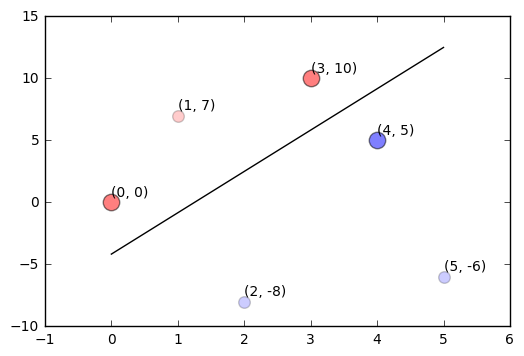

In [2]:
from cvxopt import matrix, solvers, printing
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3,suppress=True)
COLORS  = {-1.0:'red', 1.0:'blue'}

# +1 points
x1 = np.array([[ 2,-8],[ 4, 5],[ 5,-6]]).astype(float)
# -1 points
x2 = np.array([[ 0, 0],[ 1, 7],[ 3, 10]]).astype(float)

y1 = np.repeat(1.0, len(x1))
y2 = np.repeat(-1.0, len(x2))

# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)

# fit svm classifier

NUM = x.shape[0]
DIM = x.shape[1]

K = y[:, None] * x
K = np.dot(K, K.T)
P = matrix(K)
q = matrix(-np.ones((NUM, 1)))
G = matrix(-np.eye(NUM))
h = matrix(np.zeros(NUM))
A = matrix(y.reshape(1, -1))
b = matrix(np.zeros(1))
solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

norm = np.linalg.norm(w)
w, bias = w / norm, bias / norm

fig, ax = plt.subplots()
# draw separater
slope = -w[0] / w[1]
intercept = -bias / w[1]
px = np.arange(0, 6)
ax.plot(px, px * slope + intercept, 'k-')

# plot labels
for idx,d in enumerate(x):
    xi = d
    yi = y[idx]
    alphai = alphas[idx]
    print('x: %15s ,y: %6s : a= %6s' % (xi, yi, alphai))
    psize,ptran = (140,0.5) if alphai >= 0.001 else (70, 0.2)
    ax.scatter(xi[0], xi[1], c = COLORS[yi], s=psize, alpha=ptran)
    ax.text(xi[0], xi[1]+0.5, '(%d, %d)' % (xi[0], xi[1]))

plt.show()

上例大的點是找出來的 SVs, 使用 Linear Kernel

### Kernel of 2nd Polynomial Transform

b:  -1.3083, using alpha[0]:0.00001


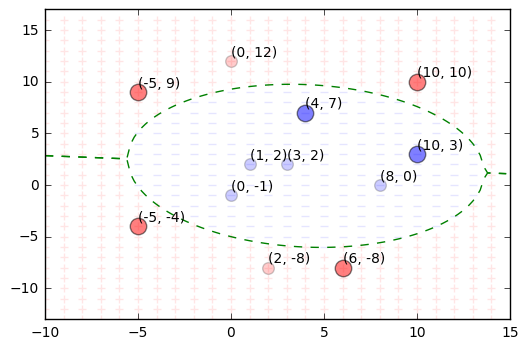

1   - (  6, -8) - alphas: 0.000007
2   - (  2, -8) - alphas: 0.000000
3   - ( 10, 10) - alphas: 0.004125
4   - (  0, 12) - alphas: 0.000000
5   - ( -5,  9) - alphas: 0.002272
6   - ( -5, -4) - alphas: 0.014649
7   - (  4,  7) - alphas: 0.015341
8   - (  3,  2) - alphas: 0.000000
9   - (  8,  0) - alphas: 0.000000
10  - (  0, -1) - alphas: 0.000000
11  - (  1,  2) - alphas: 0.000000
12  - ( 10,  3) - alphas: 0.005712
Point (5.0, 5.0) , g_svm=-1.440


In [1]:

import pandas as pd
from pandas import DataFrame as df
from cvxopt import matrix, solvers, printing
import itertools as it
import numpy as np
import matplotlib.pyplot as plt

class SVMPoly2:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r',-1:'b'}
        self.markers = {1:'+',-1:'_'}
        self.g_dense = 1
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)

    # train
    def fit(self, data):
        x = data[['x1','x2']].values
        y = data[['y']].values
        self.NUM = x.shape[0]
        self.DIM = x.shape[1]
        self.data = data
        self.x = x
        self.y = y
        self.sol, self.K = self.solver_qp()
        self.alphas = np.array(self.sol['x'])
        self.z = np.array([self.from_x_to_z(xi) for xi in x])
        self.w = self.get_w_by_ayz(self.alphas, self.y, self.z)
        self.b = self.get_b_by_ayx(self.alphas, self.y, self.x)
        # self.b = self.get_b_by_aywz(self.alphas, self.y, self.w, self.z)
        if self.visualization:
            self.draw_data(self.ax, self.x, self.y)
            self.draw_prediction_line(self.ax, self.w, self.b)
            self.draw_prediction_points(self.ax)
            plt.show();

    def solver_qp(self):
        x = self.x
        y = self.y
        K3 = self.kernel_function(x, x)
        Ky = y * y.T
        Ky = K3 * Ky
        
        y = self.y
        P = matrix(Ky)
        q = matrix(-np.ones((self.NUM, 1)))
        G = matrix(-np.eye(self.NUM))
        h = matrix(np.zeros(self.NUM))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        return sol, K3

    def kernel_function(self, a, b):
        K2 = np.dot(a, b.T)
        K3 = 1 + K2 + np.power(K2, 2)
        return K3
    
    def predict(self, p):
        K3 = svm.kernel_function(self.x, p)
        g_svm = np.dot(K3.reshape(1,len(self.x)), self.y * self.alphas) + self.b
        return g_svm

    def from_x_to_z(self, x):
        return [1, x[0], x[1], np.power(x[0],2), x[0]*x[1], x[0]*x[1], np.power(x[1],2)]
    
    def get_w_by_ayz(self, alphas, y, z):
        m_y = y.T
        m_ay = m_y * alphas.T
        m_ayz = m_ay.dot(z)
        m_w = m_ayz
        return m_w
#        w = []
#        for ii in range(0,len(z[0])):
#            wi = 0.0
#            for ni,yi in enumerate(y):
#                wi = wi + alphas[ni][0] * yi[0] * z[ni][ii]
#            w.append(wi)
#        return np.array(w)
    
    def get_b_by_ayx(self, alphas, y, x):
        b = 0.0
        for idx,ai in enumerate(alphas):
            if (ai > 0.000001):
                x_sv = x[idx]
                y_sv = y[idx]
                K3 = svm.kernel_function(self.x, x_sv)
                b = y_sv - np.dot(K3.reshape(1,len(self.x)), self.y * self.alphas)
                print('b: %8.4f, using alpha[%d]:%.5f' % (b, idx, ai))
                return b
        return b
        

    def get_b_by_aywz(self, alphas, y, w, z):
        b = 0.0
        for idx,ai in enumerate(alphas):
            if (ai > 0.000001):
                b = y[idx] - w.dot(z[idx])
                print('b: %8.4f, using alpha[%d]:%.5f' % (b, idx, ai))
                return b
        return b

    def get_x2_by_x1_wb(self, w, b, x1):
        p = [w[6]]
        p.append(w[2] + w[4]*x1 + w[5]*x1)
        p.append(w[0] + w[1]*x1 + w[3]*(x1*x1) + b)
        return np.roots(p)


    def draw_data(self, ax, x, y):
        self.g_maxs = np.max(x,axis=0)
        self.g_mins = np.min(x,axis=0)

        ax.set_xlim([self.g_mins[0] - 5.0, self.g_maxs[0] + 5.0])
        ax.set_ylim([self.g_mins[1] - 5.0, self.g_maxs[1] + 5.0])

        # plot labels
        for idx,d in enumerate(x):
            xi = d
            yi = y[idx]
            alphai = self.alphas[idx]
            psize,ptran = (140,0.5) if alphai >= 0.000001 else (70, 0.2)
            ax.scatter(xi[0], xi[1], c = self.colors[yi.item()], s=psize, alpha=ptran)
            ax.text(xi[0], xi[1]+0.5, '(%d, %d)' % (xi[0], xi[1]))

    def draw_prediction_line(self, ax, w, b):
        ln_x1s = []
        ln_x2s_a = []
        ln_x2s_b = []
        for lx in np.arange(self.g_mins[0] - 5.0, self.g_maxs[0] + 5.0, 0.2):
            lx2s = self.get_x2_by_x1_wb(self.w[0], b, lx)
            ln_x1s.append(lx)
            ln_x2s_a.append(lx2s[0])
            ln_x2s_b.append(lx2s[1])

        ax.plot(np.real(ln_x1s), np.real(ln_x2s_a), '--g')
        ax.plot(np.real(ln_x1s), np.real(ln_x2s_b), '--g')


    def draw_prediction_points(self, ax):
        g_dense = self.g_dense
        g_x1s = np.arange(self.g_mins[0] - 5.0, self.g_maxs[0] + 5.0, g_dense)
        g_x2s = np.arange(self.g_mins[1] - 5.0, self.g_maxs[1] + 5.0, g_dense)
        g_xs = np.array(list(it.product(g_x1s,g_x2s)))
        g_ys = []
        for g_xi in g_xs:
            g_svm = svm.predict(g_xi)
            g_ys.append(1 if g_svm > 0 else -1)
            
        g_ys = np.array(g_ys).reshape(len(g_xs),1)
        g_xys = np.concatenate((g_xs, g_ys), axis=1)
        for xyi in g_xys:
            ax.scatter(xyi[0], xyi[1], c = self.colors[xyi[2]], marker=self.markers[xyi[2]], s=30, alpha=0.1)

    def print_model(self):
        for idx,ai in enumerate(self.alphas):
            print('%-3d - (%3d,%3d) - alphas: %.6f' % (idx+1, self.x[idx][0], self.x[idx][1], ai))

pd.options.display.float_format = '{:,.6f}'.format
data = pd.DataFrame(columns = ['y', 'x1', 'x2'],
                  dtype=float,
                  data=[[ 1, 6, -8],
                        [ 1, 2, -8],
                        [ 1,10, 10],
                        [ 1, 0, 12],
                        [ 1,-5,  9],
                        [ 1,-5, -4],
                        [-1, 4,  7],
                        [-1, 3,  2],
                        [-1, 8,  0],
                        [-1, 0, -1],
                        [-1, 1,  2],
                        [-1,10,  3]])


#data = pd.DataFrame(columns = ['y', 'x1', 'x2'],
#                  dtype=float,
#                  data=[[ 1, 1, 1],
#                        [ 1, 1, 2],
#                        [-1, 1, 3]])
    
    
svm = SVMPoly2(visualization=True);
svm.fit(data)
svm.print_model()

p = np.array([5,5])

g_svm = svm.predict(p)
print('Point (%.1f, %.1f) , g_svm=%.3f' % (p[0], p[1], g_svm))

### Kernel of infinite dimensional transform

無限維度的轉換 $ \Phi(x) $ ? Yes, 如果 K(x,x') 可以有效率的計算出。

#### RECAP: Taylor series for exponential function

$$
\begin{align}
exp(x) = e^x & = \sum_{n=0}^{\infty} \frac{x^n}{n!}  \\
             & = \frac{x^0}{0!} + \frac{x^1}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \cdots \\
             & = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \frac{x^4}{24} + \cdots \\
\end{align}
$$

為了顯示方便，讓 Kernel function: K(x, x') 中的 x' 寫成 y。設想 K(x,y) 等於高斯函數的話，推導可得:

$
K(x, x') = K(x,y) = e^{\big( - (x-y)^2 \big)} = \exp \big( - (x-y)^2 \big) \\
= \exp\big( - (x)^2 \big) \ \times \ \exp \big( - (y)^2 \big) \ \times \ \exp \big( - (x y)^2 \big) \\
= \exp\big( - (x)^2 \big) \ \times \ \exp \big( - (y)^2 \big) \ \times \ \sum_{i=0}^{\infty} \frac{(2xy)^i}{i!} \\
= \sum_{i=0}^{\infty} \Big( e^{-x^2} \times e^{-y^2} \times \sqrt{\frac{2^i}{i!}} \times \sqrt{\frac{2^i}{i!}} \times x^i y^i  \Big) \\
= \Phi(x)^T \cdot \Phi(y)
$

所以 Dimension Transform 就是:

$$
\Phi(x) = \exp(-x^2) \times \Big( 1, \sqrt{\frac{2^1}{1!}} x^1, \sqrt{\frac{2^2}{2!}} x^2, \sqrt{\frac{2^3}{3!}} x^3, \cdots \Big)
$$

更一般化的說，若 x, x' 是無限維度的向量，也有同樣的 Gaussian Kernel:

$$
K(x, x') = K(x,y) = \exp \big( - \gamma \Vert x - y \Vert^2 \big), \text{ with } \gamma \ge 0
$$

### Hypothesis of Gaussian SVM

Gaussian Kernel: $ K(x, x') = K(x,y) = \exp \big( - \gamma \Vert x - y \Vert^2 \big), \text{ with } \gamma \ge 0 $

$$
\begin{align}
g_{SVM}(x) & = sign \Big( \sum_{SV} \alpha_n y_n K(x_n, x) + b \Big) \\
           & = sign \Big( \sum_{SV} \alpha_n y_n \exp \big( - \gamma \Vert x - x_n \Vert^2 \big) + b \Big)
\end{align}
$$

- linear combination of Gaussians centered at SVs: $ x_n $
- also called **Radial Basis Function** (RBF) Kernel.

Gaussian SVM: find $ \alpha_n $ to combine Gaussians centered at $ x_n $ and achieve large margin in infinite-dimension space.

### RBF - Gaussian Kernel SVM - Example

b:   0.6427, using alpha[0]:1.15682
b:  -0.0628, using alpha[0]:0.88479
b:  -0.1685, using alpha[0]:1.16850
b:  -0.5228, using alpha[3]:13.51905
b:   0.0615, using alpha[0]:0.94320
b:   0.0910, using alpha[0]:0.90905


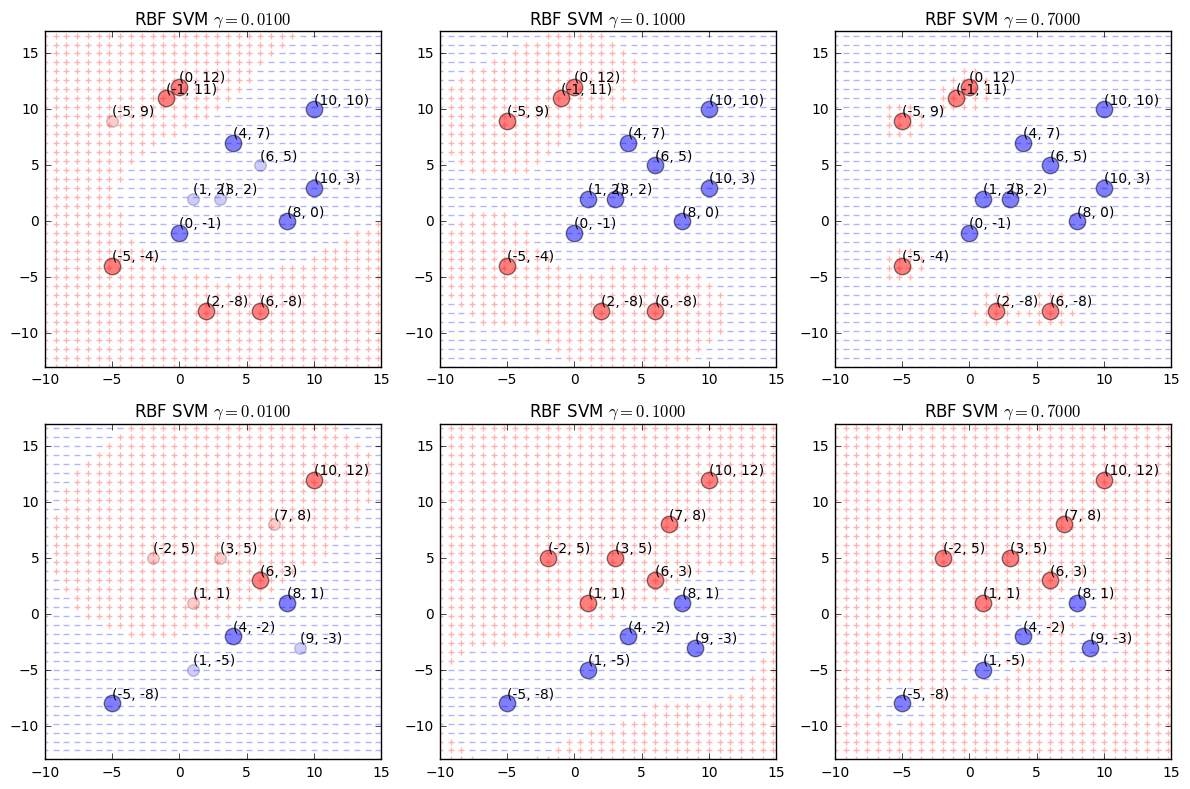

In [2]:
import pandas as pd
from pandas import DataFrame as df
from cvxopt import matrix, solvers, printing
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

class SVMPoly2:
    def __init__(self, title='', gamma=1.0, g_dense=1.0, ax = None):
        self.title = title
        self.gamma = gamma
        self.colors = {1:'r',-1:'b'}
        self.markers = {1:'+',-1:'_'}
        self.g_dense = g_dense
        self.ax = ax

    # train
    def fit(self, data):
        x = data[['x1','x2']].values
        y = data[['y']].values
        self.NUM = x.shape[0]
        self.DIM = x.shape[1]
        self.data = data
        self.x = x
        self.y = y
        self.sol, self.K = self.solver_qp()
        self.alphas = np.array(self.sol['x'])
        self.b = self.get_b_by_ayx(self.alphas, self.y, self.x)
        
        if self.ax is not None:
            self.ax.set_title(self.title)
            self.draw_data(self.ax, self.x, self.y)
            self.draw_prediction_points(self.ax)

    def solver_qp(self):
        x = self.x
        y = self.y
        K3 = self.kernel_function(a=x)
        Ky = y * y.T
        Ky = K3 * Ky
        
        y = self.y
        P = matrix(Ky)
        q = matrix(-np.ones((self.NUM, 1)))
        G = matrix(-np.eye(self.NUM))
        h = matrix(np.zeros(self.NUM))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        return sol, K3

    def kernel_function(self, a, b = None):
        if b is None:
            pairwise_sq_dists = squareform(pdist(a, 'sqeuclidean'))
            K = np.exp(-self.gamma * pairwise_sq_dists)
            return K
        else:
            p = b
            x = a
            c = x - p
            # norm^2
            n2 = np.sum(c * c, axis = 1)
            n2g = n2 * self.gamma
            Kone = np.exp(-n2g)
            return Kone
    
    def predict(self, p):
        K3 = self.kernel_function(self.x, p)
        g_svm = np.dot(K3.reshape(1,len(self.x)), self.y * self.alphas) + self.b
        return g_svm

    def get_w_by_ayz(self, alphas, y, z):
        m_y = y.T
        m_ay = m_y * alphas.T
        m_ayz = m_ay.dot(z)
        m_w = m_ayz
        return m_w
    
    def get_b_by_ayx(self, alphas, y, x):
        b = 0.0
        for idx,ai in enumerate(alphas):
            if (ai > 0.000001):
                x_sv = x[idx]
                y_sv = y[idx]
                K3 = self.kernel_function(self.x, x_sv)
                b = y_sv - np.dot(K3.reshape(1,len(self.x)), self.y * self.alphas)
                print('b: %8.4f, using alpha[%d]:%.5f' % (b, idx, ai))
                return b
        return b

    def draw_data(self, ax, x, y):
        self.g_maxs = np.max(x,axis=0)
        self.g_mins = np.min(x,axis=0)

        ax.set_xlim([self.g_mins[0] - 5.0, self.g_maxs[0] + 5.0])
        ax.set_ylim([self.g_mins[1] - 5.0, self.g_maxs[1] + 5.0])

        # plot labels
        for idx,d in enumerate(x):
            xi = d
            yi = y[idx]
            alphai = self.alphas[idx]
            psize,ptran = (140,0.5) if alphai >= 0.000001 else (70, 0.2)
            ax.scatter(xi[0], xi[1], c = self.colors[yi.item()], s=psize, alpha=ptran)
            ax.text(xi[0], xi[1]+0.5, '(%d, %d)' % (xi[0], xi[1]))

    def draw_prediction_points(self, ax):
        g_dense = self.g_dense
        g_x1s = np.arange(self.g_mins[0] - 5.0, self.g_maxs[0] + 5.0, g_dense)
        g_x2s = np.arange(self.g_mins[1] - 5.0, self.g_maxs[1] + 5.0, g_dense)
        g_xs = np.array(list(it.product(g_x1s,g_x2s)))
        g_ys = []
        for g_xi in g_xs:
            g_svm = self.predict(g_xi)
            g_ys.append(1 if g_svm > 0 else -1)
            
        g_ys = np.array(g_ys).reshape(len(g_xs),1)
        g_xys = np.concatenate((g_xs, g_ys), axis=1)
        for xyi in g_xys:
            ax.scatter(xyi[0], xyi[1], c = self.colors[xyi[2]], marker=self.markers[xyi[2]], s=20, alpha=0.3)

    def print_model(self):
        for idx,ai in enumerate(self.alphas):
            print('%-3d - (%3d,%3d) - alphas: %.6f' % (idx+1, self.x[idx][0], self.x[idx][1], ai))

pd.options.display.float_format = '{:,.6f}'.format
data1 = pd.DataFrame(columns = ['y', 'x1', 'x2'],
                  dtype=float,
                  data=[[ 1, 6, -8],
                        [ 1, 2, -8],
                        [-1,10, 10],
                        [ 1, 0, 12],
                        [ 1,-5,  9],
                        [ 1,-5, -4],
                        [ 1,-1, 11],
                        [-1, 6,  5],
                        [-1, 4,  7],
                        [-1, 3,  2],
                        [-1, 8,  0],
                        [-1, 0, -1],
                        [-1, 1,  2],
                        [-1,10,  3]])


data2 = pd.DataFrame(columns = ['y', 'x1', 'x2'],
                  dtype=float,
                  data=[[ 1, 1,  1],
                        [ 1,-2,  5],
                        [ 1, 3,  5],
                        [ 1, 6,  3],
                        [ 1, 7,  8],
                        [ 1,10, 12],
                        [-1,-5, -8],
                        [-1, 1, -5],
                        [-1, 4, -2],
                        [-1, 8,  1],
                        [-1, 9, -3]])

data_s = pd.DataFrame(columns = ['y', 'x1', 'x2'],
                  dtype=float,
                  data=[[ 1, 1, 1],
                        [ 1, 1, 2],
                        [-1, 1, 3]])    

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
svm_conf = [{ 'gamma': 0.01, 'data':data1 },
            { 'gamma':  0.1, 'data':data1 },
            { 'gamma':  0.7, 'data':data1 },
            { 'gamma': 0.01, 'data':data2 },
            { 'gamma':  0.1, 'data':data2 },
            { 'gamma':  0.7, 'data':data2 }]

axes = axes.reshape(6,)

svms = []
for idx,i in enumerate(svm_conf):
    ax = axes[idx]
    title = 'RBF SVM $ \gamma=%.4f $' % i['gamma']
    svm = SVMPoly2(title=title, g_dense=0.8, gamma=i['gamma'], ax=ax);
    svm.fit(i['data'])
    svms.append(svm)

plt.tight_layout()
plt.show()